### Name : Ashutosh Kumar
### Contact : ashutoshind2017@outlook.com

## Description
In this challenge you are asked to implement a primitive anomaly detection system for credit card transactions.
You are provided with a .csv file which mimics a real-time credit card purchase feed. The transactions have the following format:
AccountId, MerchantId, TransactionAmount
Notice that sometimes there is data corruption, and a meaningless extra column might appear. 
Your goal is to flag up anomalous transactions in real-time for further inspection by an expert. You decided to approach this problem by quantifying how much an incoming transaction deviates from the typical transaction for the customer in question.
This exercise also tests your software engineering skills, so we recommend sticking to best practices, such as clear and document code and a sufficient number of automated tests. We suggest you use Python, but you may use R, C++, or Java, if you prefer.


### Step 3: More statistics (optional)
This simple set of statistics can be extended to track the minimum and maximum transaction value, as well as the ratio between the current value and the historical minimum. Extend your program to track these 3 quantities.  


## Step 1: Data health check
Is your data in good shape? Note down how serious the data corruption is and describe how you deal with this problem.

In [57]:
# importing the required python libraries :
import pandas as pd
import numpy as np
import os

import time

import logging
import json as simplejson
from numpyencoder import NumpyEncoder

# import machine learning and stats libraries:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap

from scipy import stats
from scipy.stats import norm, skew
from statsmodels.graphics.gofplots import qqplot

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

import ipytest

## Step1 Data Healthcheck:
### Data Understbading and Data Pre-processing 

In [2]:
#To read csv File from locally stored file
df_cc = pd.read_csv("data.csv", usecols=range(0, 3))

# adding the column names as per the instructions :
df_cc.columns = ['AccountId', 'MerchantId', 'TransactionAmount']

# Checking the header data 
df_cc.head()

,AccountId,MerchantId,TransactionAmount
0,337612045,057186000156182,99.99
1,267635954,1001515665,30.01
2,23826603,000000008146524,X
3,300553673,4650693,X
4,359135601,7981962,39.99


In [3]:
# Data Issue 1 : The header or column names were missing in the dataset. Resolution : Added missing details
# Data Issue 2 : As per the the data definition only 3 columns are significant, hence reading only 3 and ignoring the erraneous
# data in the fourth column

In [4]:
# Examining the dataset shape imported:
df_cc.shape

(249999, 3)

In [5]:
# So there are 249999 rows and 3 features/columns 

In [6]:
#Examining the data frame for the shape, datatypes, NUlls etc
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249999 entries, 0 to 249998
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   AccountId          249999 non-null  int64 
 1   MerchantId         249476 non-null  object
 2   TransactionAmount  248025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.7+ MB


In [7]:
# Converting the NULL,NA missing values etc. to numpy nan as we will use it for the data cleaning:
df_cc = df_cc.replace([' ','NULL','NA'],np.nan)

In [8]:
# Another issue is data having transaction amount with the value of "X", lets find them :
(df_cc.TransactionAmount == 'X').sum()

47763

In [9]:
# Data Issue 3: TransactionAmount which is most important feature is having large number of values denoted by unknown value "X"

# Replacing X with the NAN value as X is insignificant anyways and does not give any valuable information :
df_cc['TransactionAmount'] = df_cc['TransactionAmount'].apply(lambda x: np.nan if x=='X' else x)

In [10]:
# So the datatypes are int64 for AccountId and object for the MerchantId and TransactionAmount.

# check if any null values
df_cc.isnull().sum()

AccountId                0
MerchantId             523
TransactionAmount    49737
dtype: int64

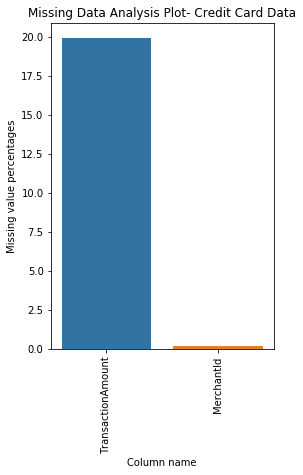

In [11]:
# Let's visualise the missing values:
missing_data_df = (df_cc.isnull().sum() / len(df_cc)) * 100
missing_data_df = missing_data_df.drop(missing_data_df[missing_data_df == 0].index).sort_values(ascending=False)

plt.figure(figsize=(4, 6))
plt.xticks(rotation="90")
plt.title('Missing Data Analysis Plot- Credit Card Data')
plt.xlabel("Column name")
plt.ylabel("Missing value percentages")
sns.barplot(x=missing_data_df.index, y=missing_data_df)
plt.show()

In [12]:
# Data Issue 4: Data is having missing values for the merchantid and TransactionAmount(more concerning to our case)

# So, 523 or 0.2 % of data is having missing merchantid and 49737 or 20% of data is having missing TransactionAmount

In [13]:
# Data Issue 5: Irrelevant column MerchantId preseent in dataset 

# Now, the column merchantid is irrelevant to the analysis of flagging the farudalent transaction, hence dropping the same:
df_cc.drop('MerchantId', axis = 1, inplace= True)

In [14]:
# let's verify if the individual transactions are for the unique customers :

# Find the unique customers:
df_cc.AccountId.nunique(dropna = True)

28676

In [15]:
# It's evident that the 249999 transactions reported are for the 28676 customers so multiple transactions are recorded for the 
# same customers

In [16]:
# Data Issue 6 : Incorrect data type for the TransactionAmount(object) , lets convert to numeric datatype:

df_cc['TransactionAmount'] = df_cc['TransactionAmount'].astype('float64')

In [17]:
# Lets check the statistical distribution of the data:
df_cc.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,AccountId,TransactionAmount
count,249999,200262
mean,2.33582e+08,74.3371
std,1.0565e+08,7266.62
min,25192,0.01
25%,1.10812e+08,8.26
50%,2.6001e+08,20
75%,3.3755e+08,50
max,3.63725e+08,3.25001e+06


In [18]:
# So the global mean of the transaction amount is 74.3371 and minimum is 0.01 and maximum is 3250010 

[Text(0.5, 1.0, 'Distribution of TransactionAmount')]

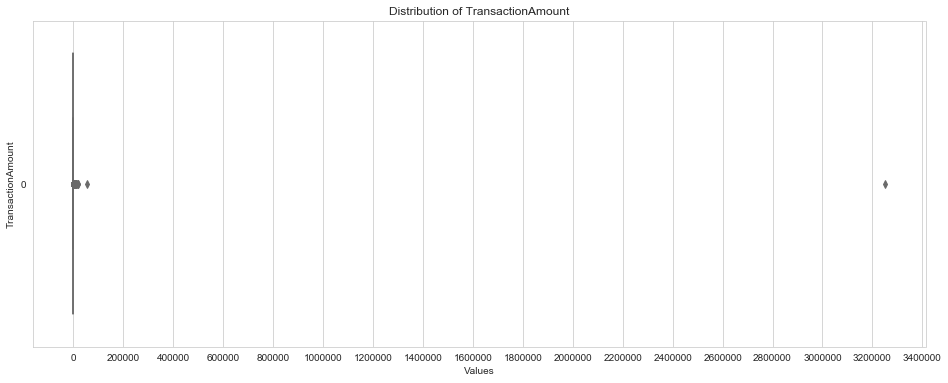

In [19]:
# Let's try to visualise the distribution of the transction amount :

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(16,6))
# Using log scale:
#ax.set_xscale("log")
ax = sns.boxplot(data=df_cc['TransactionAmount'] , orient="h", palette="Purples")
# Using the custom ticker :
ax.xaxis.set_major_locator(ticker.MultipleLocator(200000))
ax.set(ylabel="TransactionAmount")
ax.set(xlabel="Values")
ax.set(title="Distribution of TransactionAmount")
#sns.despine(trim=True,left=True)

In [20]:
# There seems to be clear statistical outlier with transaction amount more than 3200000 whereas most of the transactions are of
# amount less than 100000 

In [21]:
# Let's find and remove the extreme statistical outliers :
#train_df.drop(train_df[np.logical_and(train_df['TotalBsmtSF']>6000, train_df['SalePrice']<200000)].index, inplace=True)

df_cc[(df_cc['TransactionAmount']>3200000)]

,AccountId,TransactionAmount
137989,194165084,3250008.98


In [22]:
# Data Issue 7 : Presence of the extreme statistical outliers which is suspicious and needs to be removed 

In [23]:
# Outlier Treatment :
df_cc.drop(df_cc[(df_cc['TransactionAmount']>3200000)].index, inplace=True)

In [24]:
# We still have missing value for the transaction amount , let's impute the missing value of the transction amount by the mean 
# of the other transaction amount for the customer 

df_cc["TransactionAmount"] = df_cc.groupby("AccountId")["TransactionAmount"].transform(lambda x: x.fillna(x.mean()))

In [25]:
# check if any null values again:
df_cc.isnull().sum()

AccountId                0
TransactionAmount    36451
dtype: int64

In [26]:
round((df_cc.isnull().sum()/df_cc.isnull().count()*100),2).sort_values(ascending = False)

TransactionAmount    14.58
AccountId             0.00
dtype: float64

In [27]:
(df_cc.AccountId.notnull().nunique() & df_cc.TransactionAmount.isnull()).sum()

36451

In [28]:
# So, 14.58% (36451) of transactions have still missing values. 
# So, out of missing 49737 transaction amounts, only 36451 are remaining which is NAN after the imputation 
# This means that these ramining 36451 transactions are of no importance since only 1 transaction is present , that too
# with missing transaction amount. 

# Dropping the datapoints from the dataframe :
# Taking only rows where the transaction amount is not null
df_cc = df_cc[df_cc['TransactionAmount'].notna()]

In [29]:
df_cc.shape

(213547, 2)

In [30]:
df_cc.AccountId.nunique()

20772

In [31]:
# So, the final dataframe is having 213547 transactions for 20772 distinct customers.

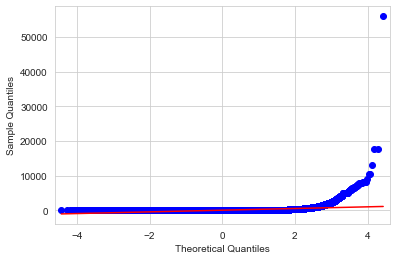

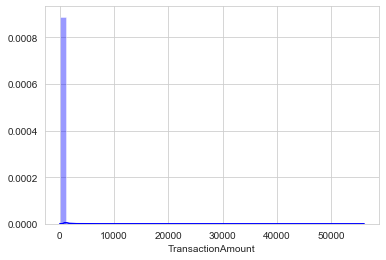

In [32]:
# Let's validate if the distribution of the variables are Normal, which might indicate the need of transformations
# that is needed 

qqplot(df_cc['TransactionAmount'], line='s')
plt.show()
sns.distplot(df_cc['TransactionAmount'], color='blue')


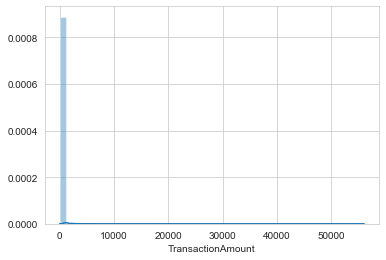

In [33]:
sns.distplot(df_cc['TransactionAmount'], hist=True)

In [34]:
# We also observe that the data given is positively skewed and having positive kurtosis as well.
print("Skewness of target variable wihout transformation: %f" % df_cc['TransactionAmount'].skew())
print("Kurtosis of target variable wihout transformation: %f" % df_cc['TransactionAmount'].kurt())

# The value closer to 0 for the skewness and kurtosis is better 

Skewness of target variable wihout transformation: 72.543939
Kurtosis of target variable wihout transformation: 13801.708062


In [35]:
df_cc.TransactionAmount.mean()

56.818945424179205

In [36]:
df_cc.TransactionAmount.std()

242.6890680437403

Skewness of transformed target variable: 0.269581
Kurtosis of transformed target variable: 0.309687


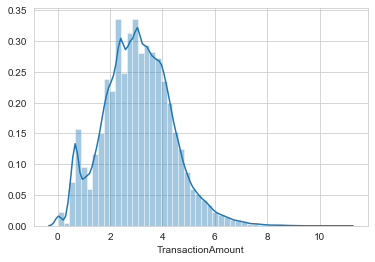

In [37]:
# This suggest that the transactional amount is not normally distributed. 
# Please note that we are need to apply the transformation inorder to get use the standard deviation method of outlier 
# detection as it is based on assumption of normality :

# Performing log transformation 
df_cc['TransactionAmount'] = np.log1p(df_cc['TransactionAmount'])

# re-checkig the variable after transformation:
sns.distplot(df_cc['TransactionAmount'], hist=True)

print("Skewness of transformed target variable: %f" % df_cc['TransactionAmount'].skew())
print("Kurtosis of transformed target variable: %f" % df_cc['TransactionAmount'].kurt())

In [38]:
# So the target variable "TransactionAmount" skewness is removed now after transformation and it is nearly normally distributed
# now.
# The skewed and long tailed distribution of the TransactionAmount is solved by applying log(1 + x) transformation. 
# This transformation reduced skewness from 1.88 to 0.12 and reduced kurtosis from 6.53 to 0.80.

In [39]:
# Let's add one more column anamoly to identify if the transaction is suspicous in the existing dataframe :

# we will identify the customers as outliers if the its more than 3 standard deviation away from the mean and add the 
# initial anamoly flag as 1 else 0 :

# This is to follow the global stats:
df_cc['anamoly'] = ((df_cc.TransactionAmount > df_cc.TransactionAmount.mean() + 3*df_cc.TransactionAmount.std()) | (df_cc.TransactionAmount < df_cc.TransactionAmount.mean() - 3*df_cc.TransactionAmount.std())).map({True:'1', False:'0'})

df_cc.head()

,AccountId,TransactionAmount,anamoly
0,337612045,4.615022,0
1,267635954,3.434310,0
4,359135601,3.713328,0
6,323678754,5.853638,0
7,359135601,3.433987,0


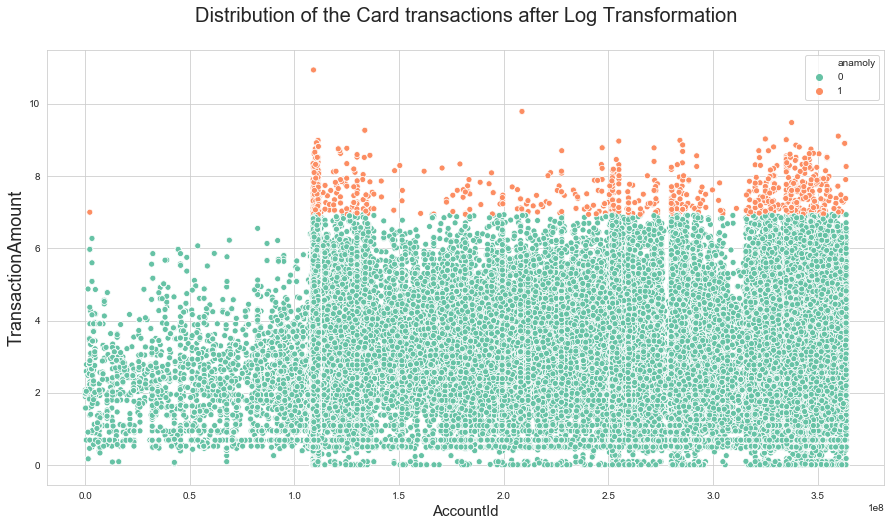

In [40]:
# Let's visualise the good and bad transactions in the given credit card data file :

fig, ax = plt.subplots(figsize = (15,8))
sns.scatterplot(x = 'AccountId', y = 'TransactionAmount', 
            hue = 'anamoly', legend = 'brief',
            ax=ax, data = df_cc , palette="Set2")
plt.xlabel('AccountId', size=15)
plt.ylabel('TransactionAmount', size=18)
plt.title('Distribution of the Card transactions after Log Transformation', size=20, y=1.05)
#plt.legend(['Legitimate Transaction', 'Suspicious Transaction'], loc='upper left')

plt.show()

In [41]:
# Here 1 refers to the suspicious transaction and 0 is legitimate transaction

In [42]:
df_anamoly_temp = df_cc[(df_cc.anamoly=='1')]

In [43]:
df_anamoly_temp.head()

,AccountId,TransactionAmount,anamoly
952,345995999,8.232235,1
953,345995999,8.445394,1
1303,329360772,8.006701,1
1407,318683547,7.055563,1
1434,273513962,6.977636,1


In [44]:
df_anamoly_temp.shape

(1034, 3)

#### So, there are 1034 transaction which are suspicous out of total 213547 trannsactions in if we use the global mean and standard deviation 


## Step 2: Simple statistics
To build up knowledge of the typical transaction, you accumulate some simple statistics about each customer. Write a program that reads event data from a file, tracks the mean transaction amount (η) for each customer and its standard deviation (σ), and prints it to standard output after every transaction.
Suppose you observe a new transaction for d dollars. You can use η and σ to detect whether it’s an anomaly by checking if d differs from η by at least 3 standard deviations. Update your program with this simple detector and output any warnings into a log.
Is your detector working reliably when it has seen very few transactions per customer? One approach to mitigate the initial lack of data is to fall back on the global statistics. Implement tracking mean transaction amount and its variance globally (for all customers) and update your detector to use this information when needed. 

In [45]:
# Assuming the data is normally distributed (it is nearly normal now)
# A standard deviation is defined such that around ~66 % of the data lies within it. And around ~99 % within three standard 
# deviations.In other words: 3 standard deviations contain always about 99 % of the data, hence there will always be 
# outlier>3std, no matter if they are outlier. So, we will flag the such transaction amount in our approach.

In [46]:
# Accumluating the statistics for each existing customer :

# Using the numpy standard devaiation and not pandas here, because we were getting nan for pandas std dev
# (numpy.std,assumes 0 degree of freedom by default, also known as population standard deviation. This gives 0 for groups 
# with one number.)
# Refer url :https://en.wikipedia.org/wiki/Bessel%27s_correction
def std(x): return np.std(x)

df_grouped=  df_cc.groupby('AccountId').TransactionAmount.agg(['mean',std,'count']).reset_index()
df_grouped.head()

,AccountId,mean,std,count
0,78678,1.989559,0.045930,8
1,193405,1.578979,0.000000,2
2,455994,1.944481,0.000000,1
3,524849,2.016868,0.260742,31
4,624019,2.783776,0.000000,1


In [47]:
# Checking the static dataframe shape :
df_grouped.shape

(20772, 4)

Let's define a function that would be able to perform below operations :
1. reads event data from a file, tracks the mean transaction amount (η) for each customer and its standard deviation (σ), and prints it to standard output after every transaction. 
2. Use simple detector and output any warnings into a log.use η and σ to detect whether it’s an anomaly by checking if d differs from η by at least 3 standard deviations.
3. In case data is less for the customer then fall back on the global statistics of mean and std dev 

In [48]:
# dropping the anamoly as we are going to update the dataframe from fresh even data :
df_cc.drop('anamoly', axis = 1, inplace= True)

In [49]:
df_cc.head(2)

,AccountId,TransactionAmount
0,337612045,4.615022
1,267635954,3.434310


In [50]:
# Assuming that the file is a csv file present with name "eventdata"  in current directory with two columns : AccountId,
# TransactionAmount
filepath = os.getcwd()
filepath

'C:\\Users\\Ashutosh'

In [51]:
def anamolies_detector(newdatafile,dataframe,filepath):
    
    # read data from event file:
    event_df= pd.read_csv("eventdata.csv")
    
    # Concatenate the event dataframe with original dataframe:
    df_final = pd.concat([dataframe, event_df], ignore_index=True)
    
    # tracking the mean and std dev for all customers :
    def std(x): return np.std(x)
    df_grouped_new=  df_final.groupby('AccountId').TransactionAmount.agg(['mean',std,'count']).reset_index()
    
    # Created temp dataframe for display purpose
    temp_df = pd.merge(df_grouped_new, event_df, on='AccountId', how='right')
    
    # Convert back AccountId to int and apply round to the mean, standard deiivations :
    temp_df['AccountId'] = temp_df['AccountId'].astype('int64')
    temp_df['mean'] = round(temp_df['mean'], 2)
    temp_df['std'] = round(temp_df['std'], 2)
    
    # Output the mean and std dev for each new transaction  
    print("The AccountId, Mean and Standard-Deviations for fresh transactions are:\n")
    for index, row in temp_df.iterrows():
        print(row['AccountId'],row['mean'], row['std'])
    
    # Detector for suspicious transaction :
    
    # Setting up the logger :
    logging.basicConfig(filename='logfile.log', level=logging.DEBUG,format='%(asctime)s %(levelname)s %(name)s %(message)s',
                        filemode='w')
    
    #define a list to accumlate anomalies
    anomalies = []
    
    for i in range(0,len(temp_df)):
        
        # Calculate global statistics:
        global_data_mean = df_final.TransactionAmount.mean()
        global_data_std = df_final.TransactionAmount.std()
        anomaly_cut_off = global_data_std * 3
        global_lower_limit  = global_data_mean - anomaly_cut_off 
        global_upper_limit = global_data_mean + anomaly_cut_off
        
        # For the existing transactions, we will use the sample(accountId) mean and SD for verification :  
        
        if (temp_df.loc[i,'count']>1)&((temp_df.loc[i,'TransactionAmount'] > temp_df.loc[i,'mean'] + 3*temp_df.loc[i,'std']) | (temp_df.loc[i,'TransactionAmount'] < temp_df.loc[i,'mean'] - 3*temp_df.loc[i,'std'])):
            print("\n WARNING !!! \n One or more suspicious transaction found related to existing customer, please check log file for details !!")
            logging.warning(' "Warning !!!, One or more suspicious transaction found related to existing customer, please check below for Account details !" ')
            anomalies.append(temp_df.loc[i,'AccountId'])
                         
        # For fresh transactions, we will use the global statistical values for validation:
        
        elif (temp_df.loc[i,'count']==1)&((temp_df.loc[i,'TransactionAmount'] > global_upper_limit) | (temp_df.loc[i,'TransactionAmount'] < global_lower_limit)):
            print("\n WARNING !!! \n One or more suspicious transaction found related to new customer, please check log file for details!!")
            logging.warning(' "Warning!!, One or more suspicious transaction found related to new customer, please check below for Account details !" ')
            anomalies.append(temp_df.loc[i,'AccountId'])
            
             # Adding anomolies to the log file :
           # logging.info("The accounts pertaining to suspicious transactions are {a} ".format(a=anomalies))
            
        else:
            print("\n One of the transaction is completed successfuly and its clean !")
            logging.info(' "INFO : One of the transaction is completed successfuly and its clean !" ')
            
    # Adding anomolies to the log file :
    logging.info("The accounts pertaining to suspicious transactions are {a} ".format(a=anomalies))
            
    return df_final,anomalies,df_grouped_new 


# Function call :
df_final,anomalies,updated_grouped_df= anamolies_detector("eventdata.csv",df_cc,filepath)

# For subsequent calls use below:
#df_final_updated,anomalies,updated_grouped_df= anamolies_detector("eventdata.csv",df_final,filepath)


The AccountId, Mean and Standard-Deviations for fresh transactions are:

105518525.0 2.43 3.59
111111111.0 40000.0 0.0
284168439.0 15.5 29.23
345995999.0 25.07 88.42
444444444.0 3000.0 0.0
777777777.0 10.0 0.0
999999999.0 80000.0 0.0

 WARNING !!! 
 One or more suspicious transaction found related to existing customer, please check log file for details !!

 WARNING !!! 
 One or more suspicious transaction found related to new customer, please check log file for details!!

 One of the transaction is completed successfuly and its clean !

 WARNING !!! 
 One or more suspicious transaction found related to existing customer, please check log file for details !!

 WARNING !!! 
 One or more suspicious transaction found related to new customer, please check log file for details!!

 One of the transaction is completed successfuly and its clean !

 WARNING !!! 
 One or more suspicious transaction found related to new customer, please check log file for details!!


In [52]:
# List the accounts with the anomalies :
print(anomalies)

[105518525, 111111111, 345995999, 444444444, 999999999]


################################################    END OF SOLUTION   ##################################################